In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

## 1. Visualize the data and Preprocess

In [67]:
# load data
ninapro_root = "./Ninapro/DB8"
print(os.path.abspath(ninapro_root))

ex3_file = os.path.join(ninapro_root, "S1_E1_A1.mat")

data = loadmat(ex3_file)

# Inspect available keys, except the ones starting with "__"
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

/data/NSSP_project2_groupK/Ninapro/DB8
Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


In [68]:
# First let's check the size of glove
print(data[subject])
glove_data = data["glove"]
print("Glove data dimension: {}".format(glove_data.shape))
#print("Glove data type: {}".format(type(glove_data)))
#Yes indeed on the scheme of the instructions we can see that we have 18 types of glove variable

stimulus = data["restimulus"] #Stimulus is the type of movement that is being performed
print("restimulus data dimension: {}".format(stimulus.shape))

repetition = data["rerepetition"] #Repetition is the number of times the movement has been repeated
print("Rerepetition data dimension: {}".format(repetition.shape))

# First let's check the size of emg
emg_data = data["emg"] #keep all 16 channels !!
print("emg data dimension: {}".format(emg_data.shape))
#print("emg data type: {}".format(type(emg_data)))
#which is right, looking at the documentation we are meant to have 18 in EMG

# Select only relevant joints -#We need to use the joint angles 3,6,8,11,14
joint_indices = [3, 6, 8, 11, 14] #Keep only the target joints of the finger
glove_fingers= glove_data[:, [i-1 for i in joint_indices]]  # zero-based indexing
print(f'Selected joints Glove: {glove_fingers.shape}')

n_channels =emg_data.shape[1]
print(f'Number of channels: {n_channels}')

n_joints =glove_fingers.shape[1]
print(f'Number of joints: {n_joints}')

NameError: name 'subject' is not defined

In [ ]:
#plot 1st channel 
plt.close("all")
fig, ax = plt.subplots()
ax.plot(emg_data[:, 5])   
ax.set_title("EMG signal")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

In [ ]:
#We need to preprocess EMG and print the absolute value
emg_data_rect = np.abs(emg_data)

plt.close("all")
fig, ax = plt.subplots()
ax.plot(np.abs(emg_data_rect))   
ax.set_title("EMG signal")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

Checking if the powerline noise is influencing the signal or not enough to do powerline filtering. it's electrical contamination at 50hz (EU) or 60hz (US). As we can see this filtering looks to have already been done.

In [ ]:
# Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg_data[:, 8], fs=2400, nperseg=2048) #just checking for channel #8 here !

# IMPORTANT to take emg_data and not emg_data_rect

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3)) 
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

the "holes" that we are seeing might be the preprocess already done on the dataset to delete the powerline noise and its harmonics. As we can see the first hole on the left table is at 50hz !

In [ ]:
mov_mean_size = 400 # moving average filter of a length of 50 samples 
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size 
EMG_envelopes = convolve1d(np.abs(emg_data), weights=mov_mean_weights, axis=0) # we take the absolute value of emg again !
#convolve1d smooths absolute EMG 

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(EMG_envelopes[:, 0],color = 'cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

finger_angle_ax = ax.twinx()
finger_angle_ax.plot(glove_fingers, color="darkorange", label="Angle of finger") #important to take data of glove_fingers 
finger_angle_ax.set_ylabel("Angle of finger")# and not take glove_data // or we could take glove_data[:, target_joints]
finger_angle_ax.grid(False)

# Get handles and labels for legend
emg_handles, emg_labels = ax.get_legend_handles_labels()
finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()

# Combine handles and labels
combined_handles = emg_handles + finger_angle_handles
combined_labels = emg_labels + finger_angle_labels

# Create a single legend
ax.legend(combined_handles, combined_labels, loc='upper left')
plt.tight_layout()

Here we plotted the EMG enveloppe and the angles of the 5 joint angles of interests (the 5 fingers)

EMG_enveloppes has same shape as emg_data, but each channel is smoothed over 50 samples

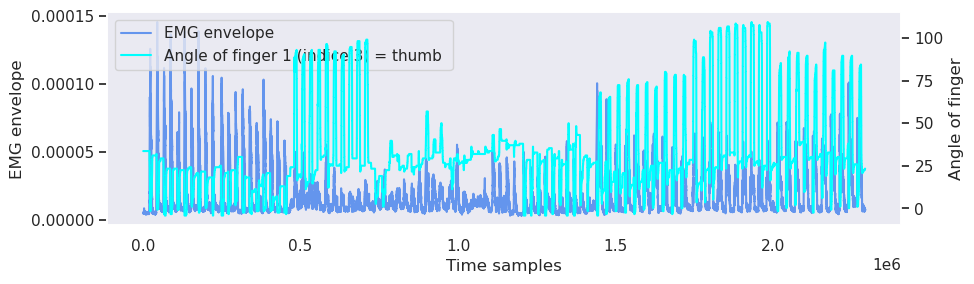

In [34]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(EMG_envelopes[:, 0],color = 'cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

finger_angle_ax = ax.twinx()
finger_angle_ax.plot(glove_fingers[:,1], color="cyan", label="Angle of finger 1 (indice 3) = thumb ") #important to take data of glove_fingers 
finger_angle_ax.set_ylabel("Angle of finger")# and not take glove_data // or we could take glove_data[:, target_joints]
finger_angle_ax.grid(False)

# Get handles and labels for legend
emg_handles, emg_labels = ax.get_legend_handles_labels()
finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()

# Combine handles and labels
combined_handles = emg_handles + finger_angle_handles
combined_labels = emg_labels + finger_angle_labels

# Create a single legend
ax.legend(combined_handles, combined_labels, loc='upper left')
plt.tight_layout()

Here we plotted the EMG enveloppe and the joint angle of the joint 3, which is the first, the thumb.

In this project, we are predicting finger joint angles from EMG signals recorded in the NinaPro DB8 dataset (subject 1, experiment 1, acquisition 1). The data consist of EMG recordings from 16 sensors and kinematic measurements of 18 glove joints, sampled at 2 kHz. We focus on five joints of interest: 3 (thumb), 6 (index), 8 (middle), 11 (ring), and 14 (little finger).

Because the dataset contains repetitions of the same movements (10 repetitions per movement), splitting the data randomly across timepoints would result in training and testing windows from the same repetition being mixed. This causes a major issue: the model could see nearly identical EMG patterns during training and test, effectively “peeking into the future.” This produces an artificially low MSE but does not reflect real generalization to new trials or movements.

To avoid this problem, the data are split by repetition:
	•	Repetitions 1–8 are assigned to the training set.
	•	Repetitions 9–10 are assigned to the test set.
	•	A validation set is carved out from the training repetitions to tune hyperparameters.

After this split, time-window extraction and feature calculation are performed independently for each set. This ensures that each window in the test set comes from a repetition unseen during training, providing a fair evaluation of the regressor’s generalization.

This approach preserves the temporal structure of the EMG and finger kinematics, and aligns with the intended use case for prosthetic control: predicting finger movements in new repetitions of the same actions.

In [56]:
rep = repetition.reshape(-1)
#may  be rerepetition I'm not sure !

#Unique repetitions excluding 0 (rest periods)
unique_reps = np.unique(rep)
unique_reps = unique_reps[unique_reps != 0]

# Define validation repetitions
# Training reps = 1–6, Validation reps = 7–8
train_reps = unique_reps[:6]    # reps 1–6 for training
val_reps   = unique_reps[6:8]   # reps 7–8 for validation
test_reps  = unique_reps[8:]    # reps 9–10 for testing

#Create boolean masks
train_mask = np.isin(rep, train_reps)
val_mask   = np.isin(rep, val_reps)
test_mask  = np.isin(rep, test_reps)

#Split the data
emg_train = emg_data[train_mask]
emg_val   = emg_data[val_mask]
emg_test  = emg_data[test_mask]
#emg_train = EMG_envelopes[train_mask]
#emg_val   = EMG_envelopes[val_mask]
#emg_test  = EMG_envelopes[test_mask]

labels_train = glove_fingers[train_mask]
labels_val   = glove_fingers[val_mask]
labels_test  = glove_fingers[test_mask]

#Print shapes to verify
print(f"EMG train: {emg_train.shape}, Labels train: {labels_train.shape}")
print(f"EMG val:   {emg_val.shape},   Labels val:   {labels_val.shape}")
print(f"EMG test:  {emg_test.shape},  Labels test:  {labels_test.shape}")

EMG train: (1409958, 16), Labels train: (1409958, 5)
EMG val:   (434285, 16),   Labels val:   (434285, 5)
EMG test:  (438405, 16),  Labels test:  (438405, 5)


# 2. Perform sliding windows
To process the dataset efficiently, we divide it into overlapping sliding windows. 
This approach allows us to extract smaller segments of the EMG data, each corresponding to a specific time interval. 
The sliding window technique ensures that we capture temporal patterns in the signal by dividing it into time segments,
while maintaining continuity through overlapping segments.

In [57]:
fs = 2000  # [Hz], it should always be 2400hz
emg_window_length_sec = 100e-3 #500e-3  # [s]
incremental_window_length_sec = 50e-3  # [s]  IT should be 10ms but kills the kernel so for now let's do 50 ms

In [58]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [59]:
from sklearn.model_selection import train_test_split
# extract over lapping time windows on the whole dataset before splitting the dataset into train, validation and test

X_train_w,y_train_w = extract_time_windows_regression(emg_train,labels_train,fs,emg_window_length_sec,incremental_window_length_sec)
X_test_w,y_test_w = extract_time_windows_regression(emg_test,labels_test,fs,emg_window_length_sec,incremental_window_length_sec)
X_val_w,y_val_w = extract_time_windows_regression(emg_val,labels_val,fs,emg_window_length_sec,incremental_window_length_sec)


print(f"EMG train data shape: {X_train_w.shape}, Train label shape: {y_train_w.shape}")
print(f"EMG test data shape: {X_test_w.shape}, Test label shape: {y_test_w.shape}")
print(f"EMG validation data shape: {X_val_w.shape}, Validation label shape: {y_val_w.shape}")

#shapes seems right, 16 for the 16 EMG channels
# 18 for the 18 joint

EMG train data shape: (14098, 200, 16), Train label shape: (14098, 200, 5)
EMG test data shape: (4383, 200, 16), Test label shape: (4383, 200, 5)
EMG validation data shape: (4341, 200, 16), Validation label shape: (4341, 200, 5)


Expected results : 
windows length = 50 ms = 0.05 s. Window sample = fs * 0.05 = 2400 * 0.05 = 120 samples

EMG train ==> each 120 timepoints long, 16 emg channels
labels train ==>120 timepoints, and 5 joint angles (the 5 target joints from the 5 fingers)

EMG test ==> 120 timepoints long, 16 emg channels
labels test ==> 120 timepoints, and 5 joint angles 

our test set is smaller than train set !

# 3. Extract a set of features, normalize them and visualize the correlation between them

In [60]:
def extract_features(EMG_windows: np.ndarray, labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean, the standard deviation and the maximum amplitude of each window and the mean of the labels window
    """
    # along axis 1, which is the time axis
    EMG_mean = np.mean(EMG_windows, axis=1)
    EMG_std = np.std(EMG_windows, axis=1)
    EMG_max_amplitude = np.max(EMG_windows, axis=1)
    RMS = np.sqrt(np.mean(EMG_windows**2, axis=1))
    iEMG = np.sum(np.abs(EMG_windows), axis=1)
    
    labels_mean = np.mean(labels_windows,axis=1)
    
    # Concatenate the mean and std of each window
    emg_extracted_features = np.concatenate((EMG_mean, EMG_std, EMG_max_amplitude,RMS,iEMG), axis=1)
    return emg_extracted_features, labels_mean

In [61]:
X_train_ef, y_train_mean = extract_features(X_train_w,y_train_w)
X_test_ef, y_test_mean = extract_features(X_test_w,y_test_w)
X_val_ef, y_val_mean = extract_features(X_val_w,y_val_w)
#ef = extracted_features

print("EMG train extracted features shape: {}, Finger labels feature shape:{}".format(X_train_ef.shape, y_train_mean.shape))
print("EMG test extracted features shape: {}, Finger labels feature shape:{}".format(X_test_ef.shape, y_test_mean.shape))
print("EMG val extracted features shape: {}, Finger labels feature shape:{}".format(X_val_ef.shape, y_val_mean.shape))

EMG train extracted features shape: (14098, 80), Finger labels feature shape:(14098, 5)
EMG test extracted features shape: (4383, 80), Finger labels feature shape:(4383, 5)
EMG val extracted features shape: (4341, 80), Finger labels feature shape:(4341, 5)


# Normalize and visualize correlation between features

In [62]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#scaler = StandardScaler()
#emg_train_norm = scaler.fit_transform(emg_train_extracted_features) #now each feature has mean 0,std 1 across all windows
#emg_test_norm = scaler.transform(emg_test_extracted_features)
#emg_val_norm = scaler.transform(emg_val_extracted_features)

#let's try and normalize angles (labels), for better prediction

scaler= StandardScaler()

X_train_s = scaler.fit_transform(X_train_ef)
X_val_s   = scaler.transform(X_val_ef)
X_test_s  = scaler.transform(X_test_ef)

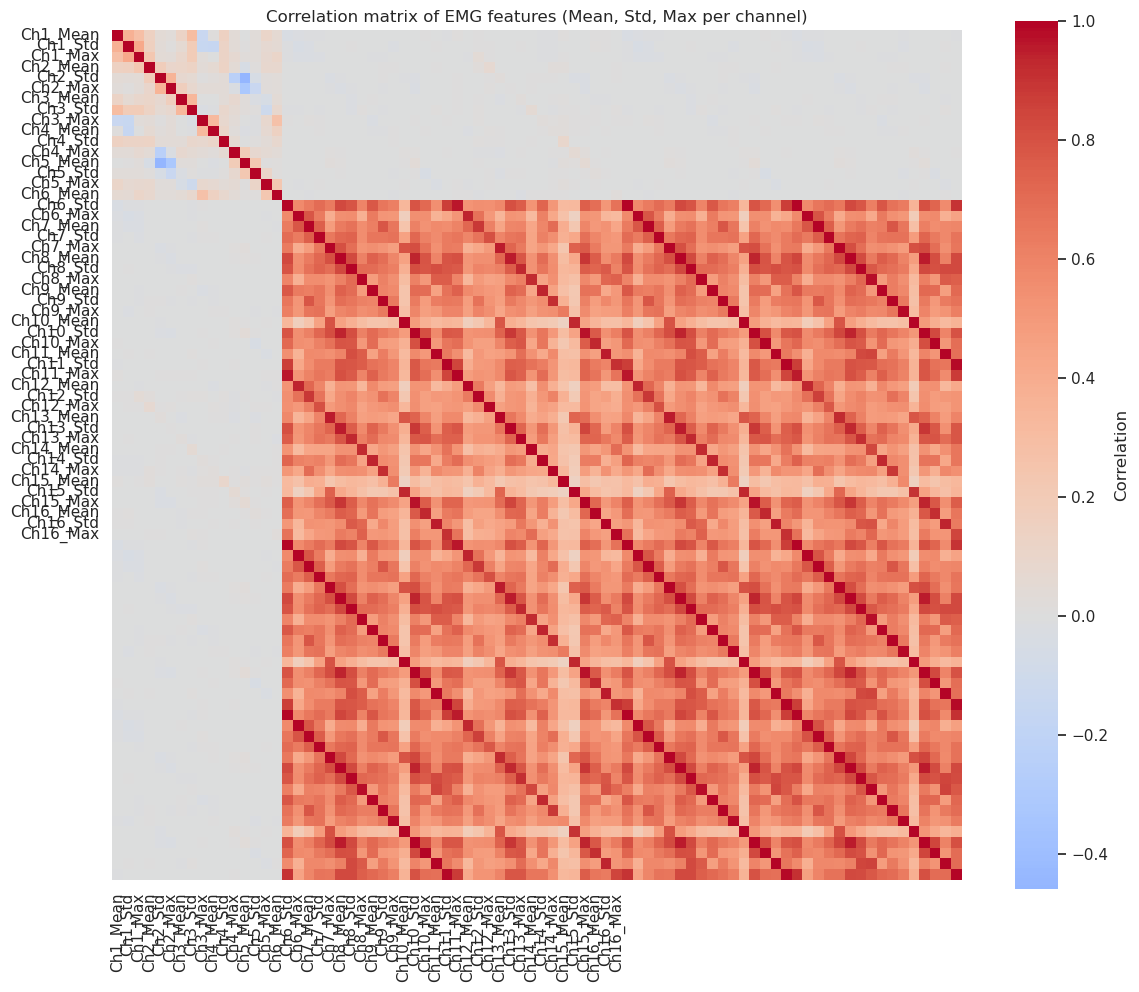

In [63]:

# 2. Compute correlation matrix
#corr_matrix = np.corrcoef(emg_train_norm, rowvar=False)  # shape (48,48)
corr_matrix = np.corrcoef(X_train_s, rowvar=False)  # shape (48,48)

# 3. Build readable labels: "Ch1_Mean", "Ch1_Std", "Ch1_Max", ...
n_channels = 16
feature_types = ["Mean", "Std", "Max"]
labels = []
for ch in range(1, n_channels+1):
    for ftype in feature_types:
        labels.append(f"Ch{ch}_{ftype}")

# 4. Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, xticklabels=labels, yticklabels=labels, cmap="coolwarm", center=0,
            cbar_kws={'label': 'Correlation'}, square=True)
plt.title("Correlation matrix of EMG features (Mean, Std, Max per channel)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Perform Regression on Kinematics - Random Forest

In [64]:
from sklearn.ensemble import RandomForestRegressor


#initialazing the regressor
regressor = RandomForestRegressor(
    n_estimators=50,        # ↓ trees
    max_depth=15,           # limit tree growth
    min_samples_leaf=20,    # smoother regression
    n_jobs=-1,              # use all CPU cores
    random_state=42
)

#Fit on training set
regressor.fit(X_train_s, y_train_mean)

y_pred= regressor.predict(X_test_s)

In [65]:
from sklearn.metrics import mean_squared_error,r2_score

#Evaluate by Computing the mean squared error
mse_per_joint = mean_squared_error(y_test_mean, y_pred)
r2_per_joint = r2_score(y_test_mean, y_pred)

print("MSE per joint (real):")
for j in range(y_test_mean.shape[1]):
    print(j, mean_squared_error(y_test_mean[:,j], y_pred[:,j]), r2_score(y_test_mean[:,j], y_pred[:,j]))

MSE per joint (real):
0 131.64299285411337 0.5312050681276057
1 351.9485450870384 0.5155641624801217
2 647.0686675279782 0.6018568716973958
3 427.9009625706246 0.7095137848713173
4 409.8409449419943 0.7542130268875856


Visualization of the error

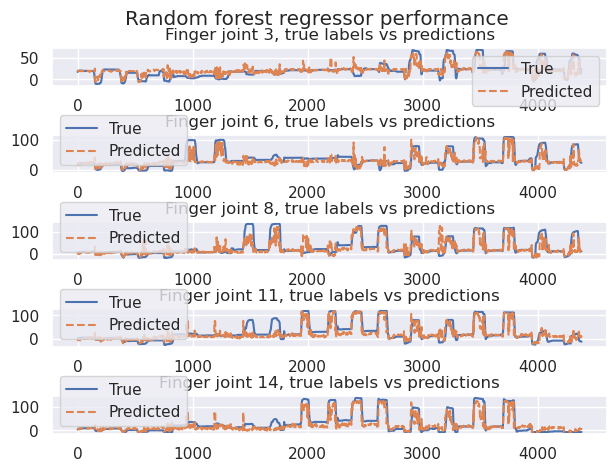

In [46]:
# Plot the true and predicted values for finger angle 5
plt.close("all")
fig, ax = plt.subplots(5, 1)
fig.tight_layout()
fig.subplots_adjust(top= 0.9)
fig.suptitle("Random forest regressor performance")

ax[0].plot(y_test_mean[:,0], label="True")
ax[0].plot(y_pred[:,0], linestyle="--", label="Predicted")
ax[0].set_title("Finger joint 3, true labels vs predictions")
ax[0].legend()

ax[1].plot(y_test_mean[:,1], label="True")
ax[1].plot(y_pred[:,1], linestyle="--", label="Predicted")
ax[1].set_title("Finger joint 6, true labels vs predictions")
ax[1].legend()

ax[2].plot(y_test_mean[:,2], label="True")
ax[2].plot(y_pred[:,2], linestyle="--", label="Predicted")
ax[2].set_title("Finger joint 8, true labels vs predictions")
ax[2].legend()

ax[3].plot(y_test_mean[:,3], label="True")
ax[3].plot(y_pred[:,3], linestyle="--", label="Predicted")
ax[3].set_title("Finger joint 11, true labels vs predictions")
ax[3].legend()

ax[4].plot(y_test_mean[:,4], label="True")
ax[4].plot(y_pred[:,4], linestyle="--", label="Predicted")
ax[4].set_title("Finger joint 14, true labels vs predictions")
ax[4].legend()

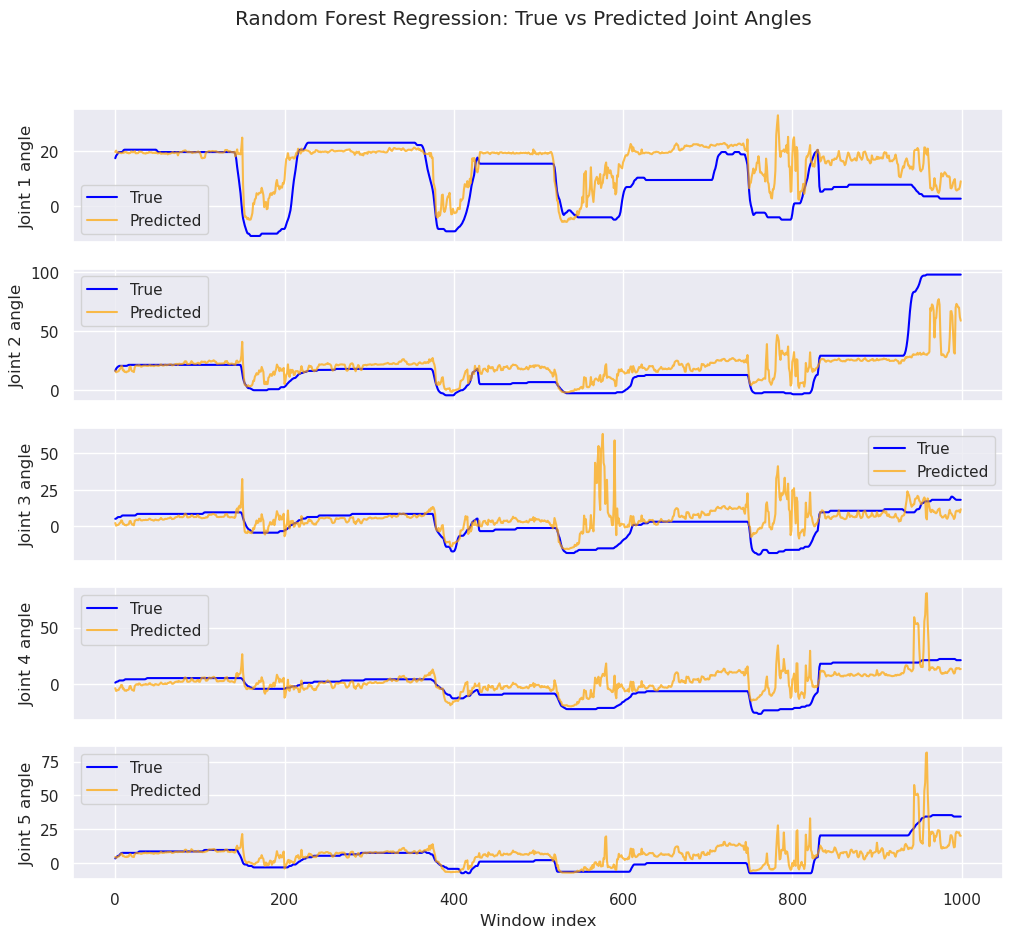

In [47]:
# --- VISUALIZATION ---

# Plot true vs predicted for each joint (first 500 windows as example)
n_plot = 1000
fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
for i in range(5):
    axes[i].plot(y_test_mean[:n_plot, i], label='True', color='blue')
    axes[i].plot(y_pred[:n_plot, i], label='Predicted', color='orange', alpha=0.7)
    axes[i].set_ylabel(f'Joint {i+1} angle')
    axes[i].legend()
axes[-1].set_xlabel('Window index')
plt.suptitle('Random Forest Regression: True vs Predicted Joint Angles')
plt.show()